In this notebook, we will display the evaluation of the trained Agent with the Multi-Period EIIE policy function. We will show the portfolio performance over time, the Agent's actions and the Reward.

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from modules.scalers import GroupByScaler
from sklearn.preprocessing import MaxAbsScaler
import json
import torch
import numpy as np

from modules.environment import MultiPeriodPortfolioOptimizationEnv
from modules.architectures import MultiPeriodEIIE
from modules.models import DRLAgent

from modules.utils import calculate_max_draw_down

sns.set()

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## 2. Getting Config Data

In [2]:
config_file_name = "config.json"
with open(config_file_name, "r") as jsonfile:
    config_data = json.load(jsonfile)

In [3]:
cac40 = config_data["tickers"]["Europe"]["CAC_40"]
NUM_ASSETS = len(cac40)
len(cac40)

40

In [4]:
start_date = config_data["timeframe"]["cac40"]["start_date"]
end_date = config_data["timeframe"]["cac40"]["end_date"]
data_interval = config_data["data_interval"]
test_ratio = config_data["train_test_ratio"]
random_seed = config_data["random_state_seed"]

## 3. Data Retrieval

In [6]:
portfolio_raw_df = yf.download(tickers=cac40, start=start_date, end=end_date, interval=data_interval)

portfolio_raw_df.fillna(method="bfill", inplace=True)
portfolio_raw_df = portfolio_raw_df.stack(level=1).rename_axis(["Date", "Ticker"]).reset_index(level=1)
portfolio_raw_df = portfolio_raw_df.drop("Adj Close", axis=1)
portfolio_raw_df.columns.name = None
portfolio_raw_df = portfolio_raw_df.reset_index()
portfolio_raw_df.Date = portfolio_raw_df.Date.astype(str)
portfolio_raw_df.columns = ["date", "tic", "close", "high", "low", "open", "volume"]
portfolio_raw_df = portfolio_raw_df[["date", "tic", "close", "high", "low", "volume"]]

df_portfolio_raw_train, df_portfolio_raw_test = train_test_split(portfolio_raw_df, test_size=test_ratio, shuffle=False, random_state=random_seed)
df_portfolio_train = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(df_portfolio_raw_train)
df_portfolio_test = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(df_portfolio_raw_test)


[*********************100%%**********************]  40 of 40 completed

2 Failed downloads:
['STLA.PA', 'STM.PA']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
/var/folders/02/rmgfx9wj0s99nn4tzfthtrnc0000gn/T/ipykernel_30982/749921926.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  portfolio_raw_df.fillna(method="bfill", inplace=True)
/var/folders/02/rmgfx9wj0s99nn4tzfthtrnc0000gn/T/ipykernel_30982/749921926.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  portfolio_raw_df = portfolio_raw_df.stack(level=1).rename_axis(["Date", "Ticker"]).reset_index(level=1)


## 4. DRL Test Environment
### 4.1 Hyperparameter selection

In [7]:
# SETTING HYPERPARAMETERS
FEATURES = ["close", "high", "low", "volume"]
N = config_data["lookback_window"]
T = config_data["multi_step_horizon"]
NUM_FEATURES = len(FEATURES)
experiment_type = "EIIE_CAC40" 
N, T

(24, 3)

### 4.2 Test Environment initialization

In [8]:
test_environment = MultiPeriodPortfolioOptimizationEnv(
    df_portfolio_test,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=N,
    multi_period_horizon=T,
    features=FEATURES,
    normalize_df=None,
    is_train_mode=False,
    experiment_type=experiment_type
)

### 4.3 Agent Initialization

In [9]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.0001,
    "policy": MultiPeriodEIIE,
    "multi_period_horizon": T
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "initial_features": NUM_FEATURES,
    "k_size": 5, # Size of Initial Kernel
    "time_window": N,
    "prediction_horizon": T
}

model = DRLAgent(test_environment).get_model("pg", device, model_kwargs, policy_kwargs)

In [10]:
policy = MultiPeriodEIIE(
    initial_features=NUM_FEATURES,
    k_size=5,
    time_window=N,
    prediction_horizon=T
)
policy.load_state_dict(torch.load(f"models/policy_{experiment_type}.pt"))

<All keys matched successfully>

### 4.4 Agent Evaluation

In [11]:
DRLAgent.DRL_validation(model=model, test_env=test_environment, policy=policy)

Initial portfolio value:100000
Final portfolio value: 272564.5930133884
Final accumulative portfolio value: 2.725645930133884
Maximum DrawDown: -0.5260758899105635
Sharpe ratio: 0.7536816250122447


## 5. Performance Visualization
### 5.1 Portfolio Cumulative Return

In [12]:
portfolio_performance = pd.DataFrame(data={"Date": test_environment._date_memory, "cac40": test_environment._asset_memory["final"]})

In [13]:
portfolio_performance = portfolio_performance.set_index(pd.to_datetime(portfolio_performance.Date)).drop("Date", axis=1)
portfolio_performance["MDD"] = portfolio_performance.apply(lambda x: calculate_max_draw_down(x))
portfolio_performance["Reward"] = test_environment._portfolio_reward_memory

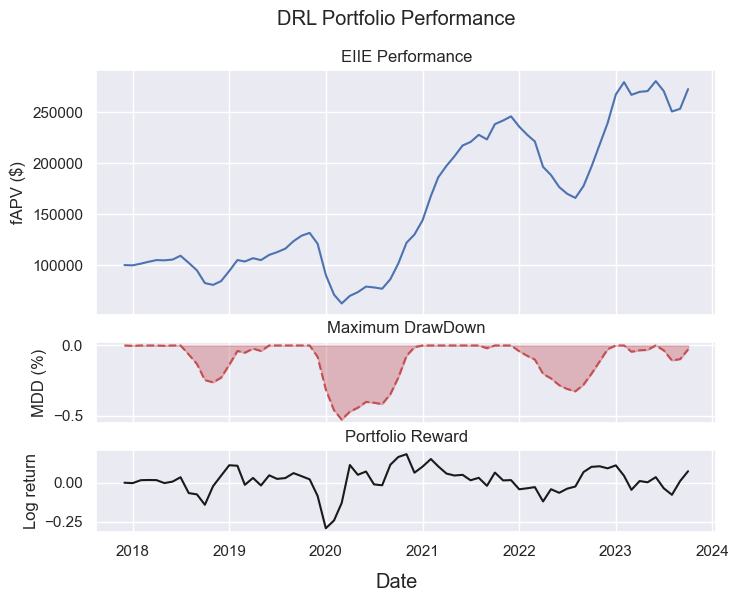

In [14]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(8,6), height_ratios=[3,1,1])
ax[0].plot(portfolio_performance.index, portfolio_performance.cac40)
ax[1].plot(portfolio_performance.index, portfolio_performance.MDD, linestyle='--', color='r')
ax[1].fill_between(portfolio_performance.index, y1=portfolio_performance.MDD, color='r', alpha=0.35)
ax[2].plot(portfolio_performance.index, portfolio_performance.Reward, color='k')
ax[0].set_ylabel("fAPV ($)")
ax[0].set_title("EIIE Performance")
ax[1].set_ylabel("MDD (%)")
ax[1].set_title("Maximum DrawDown")

ax[2].set_ylabel("Log return")
ax[2].set_title("Portfolio Reward")

fig.suptitle("DRL Portfolio Performance")
fig.supxlabel("Date")
plt.show()

### 5.2 Agent's Weight Actions

In [15]:
agent_actions = np.stack(test_environment._actions_memory)[1:, 0, 1:]

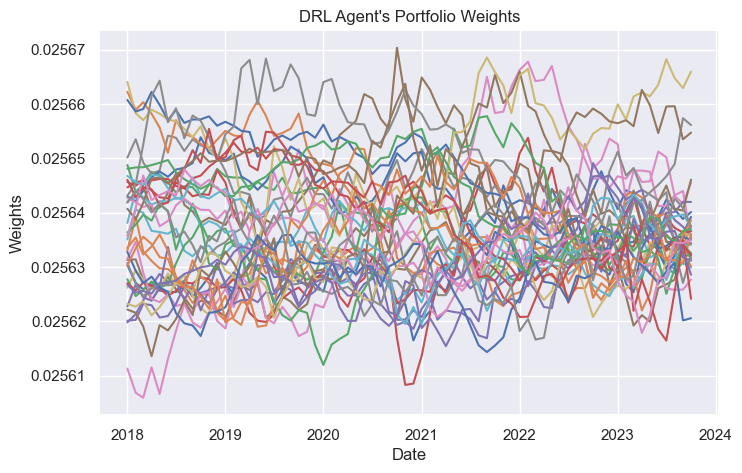

In [16]:
plt.figure(figsize=(8,5))
plt.plot(portfolio_performance.index[1:], agent_actions)
plt.title("DRL Agent's Portfolio Weights")
plt.xlabel("Date")
plt.ylabel("Weights")
plt.show()